In [1]:
import os
import sys
import torch

import psdr_jit as psdr
import drjit
from drjit.cuda.ad import Int as IntD, Float as FloatD, Matrix4f as Matrix4fD, Array3f as Vector3fD, Array2f as Vector2fD
from drjit.cuda import Float as FloatC, Matrix4f as Matrix4fC, Array3f as Vector3fC
from drjit.cuda import PCG32 as PCG32C, UInt64 as UInt64C

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from image_util import *


In [2]:
sc = psdr.Scene()
sc.opts.spp = 128
sc.opts.sppe = 0
sc.opts.sppse = 0
sc.opts.height = 128 
sc.opts.width = 128

# integrator = CollocatedIntegrator(sc.opts.spp, sc.opts.sppe, sc.opts.sppse, sc.opts.height, sc.opts.width, 1000000.0)
integrator = psdr.PathTracer(1)


In [3]:
sensor = psdr.PerspectiveCamera(80, 0.000001, 10000000.)
to_world = Matrix4fD([[-1.,0.,0.,0.],
                     [0.,1.,0.,0.],
                     [0.,0.,-1.,0.],
                     [0.,0.,0.,1.],])
sensor.to_world = to_world
sc.add_Sensor(sensor)


In [4]:
mybsdf1 = psdr.MicrofacetBSDF([0.2, 0.9, 0.9], [0.01, 0.01, 0.01], 0.3)
sc.add_BSDF(mybsdf1, "bunny")


In [5]:
sc.add_Mesh("./data/mesh/bunny_low.obj", Matrix4fC([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,-100.],[0.,0.,0.,1.]]), "bunny", None)

sc.add_EnvironmentMap("./data/envmap/ballroom_1k.exr", drjit.scalar.Matrix4f([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]]), 1.0)


with drjit.suspend_grad():
    sc.configure()
    sc.configure([0])

Ori Image

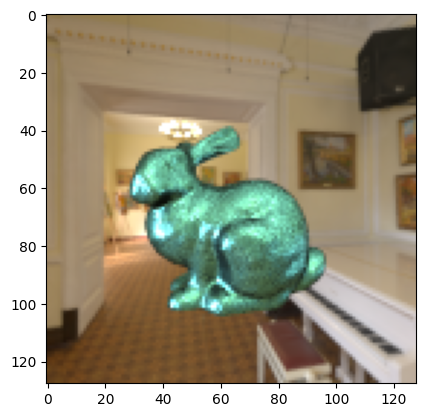

In [6]:
sc.opts.spp = 128
sc.opts.sppe = 0
sc.opts.sppse = 0

P = FloatD(0.) 
drjit.enable_grad(P) 

sc.param_map["Mesh[0]"].set_transform(Matrix4fD([[1.,0.,0.,P*100],[0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.],]))
sc.configure([0])

img = integrator.renderD(sc, 0)
org_img = img.numpy().reshape((sc.opts.width, sc.opts.height, 3))

org_img = to_srgb(np.asarray(org_img))
imgplot = plt.imshow(org_img)


## Interior Term

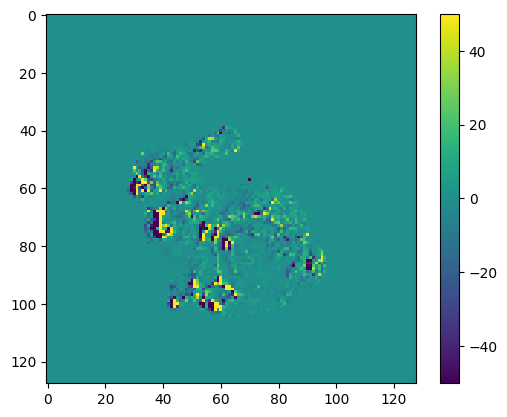

In [7]:
drjit.set_grad(P, 1.0)
drjit.forward_to(img)
diff_img = drjit.grad(img)
diff_img = diff_img.numpy().reshape((sc.opts.width, sc.opts.height, 3)).mean(axis=2)
plt.imshow(diff_img, interpolation='none', vmin=-50, vmax=50, cmap=plt.cm.viridis)
plt.colorbar()


## Primary Boundary Term

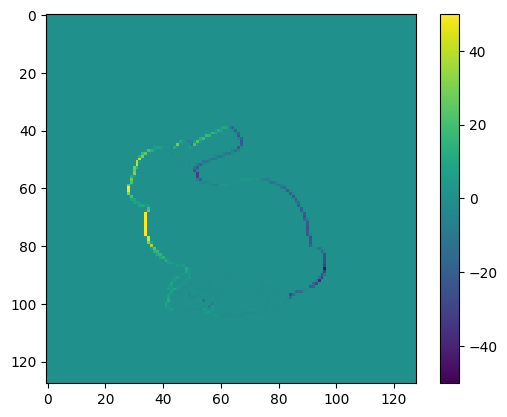

In [8]:
sc.opts.spp = 0
sc.opts.sppe = 128
sc.opts.sppse = 0

P = FloatD(0.) 
drjit.enable_grad(P) 

sc.param_map["Mesh[0]"].set_transform(Matrix4fD([[1.,0.,0.,P*100],[0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.],]))
sc.configure([0])

img = integrator.renderD(sc, 0)
drjit.set_grad(P, 1.0)
drjit.forward_to(img)
diff_img = drjit.grad(img)
diff_img = diff_img.numpy().reshape((sc.opts.width, sc.opts.height, 3)).mean(axis=2)
plt.imshow(diff_img, interpolation='none', vmin=-50, vmax=50, cmap=plt.cm.viridis)
plt.colorbar()


## Secondary Boundary Term

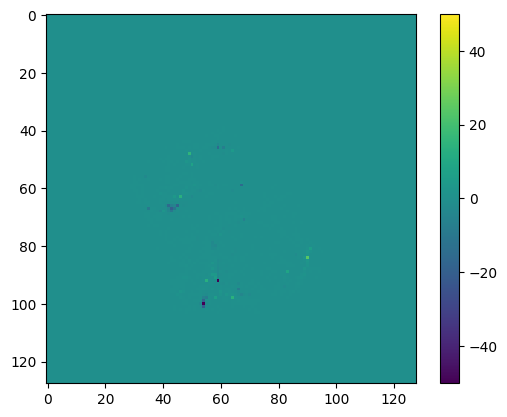

In [9]:
sc.opts.spp = 0
sc.opts.sppe = 0
sc.opts.sppse = 128

P = FloatD(0.) 
drjit.enable_grad(P) 

sc.param_map["Mesh[0]"].set_transform(Matrix4fD([[1.,0.,0.,P*100],[0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.],]))
sc.configure([0])

img = integrator.renderD(sc, 0)
drjit.set_grad(P, 1.0)
drjit.forward_to(img)
diff_img = drjit.grad(img)
diff_img = diff_img.numpy().reshape((sc.opts.width, sc.opts.height, 3)).mean(axis=2)
plt.imshow(diff_img, interpolation='none', vmin=-50, vmax=50, cmap=plt.cm.viridis)
plt.colorbar()
